# Lab work on MNIST classification using multiple machine learning algorithms 

**Objective of the work**.

The purpose of this lab work is to learn multiple machine learning algorithms for classifying handwritten digit images from a MNIST dataset.

**Work Objectives**.

* Study the MNIST dataset and its structure
* Study and implement **some** machine learning algorithms for MNIST classification
* Train models on the MNIST dataset
* Evaluate the performance of the models and compare the results
* Suggest improvements and optimizations for the models

**MNIST dataset**.

The MNIST dataset is a standard dataset for pattern recognition tasks. It consists of 70,000 handwritten digit images from 0 to 9, each image is 28x28 pixels.

## Import libraries

To work with data and models, we need the following libraries:

* numpy
* pandas
* matplotlib
* scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [90]:
# Loading data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Create a dataframe from MNIST data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='pandas')

# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)

(70000, 784) (70000,)
(56000, 784) (56000,)


In [91]:
X.head(10)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
X_train.head(10)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
57050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37530,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
y.head(10)

0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [140]:
y_train.head(10)

print(list(y_train.cat.categories))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Data visualization

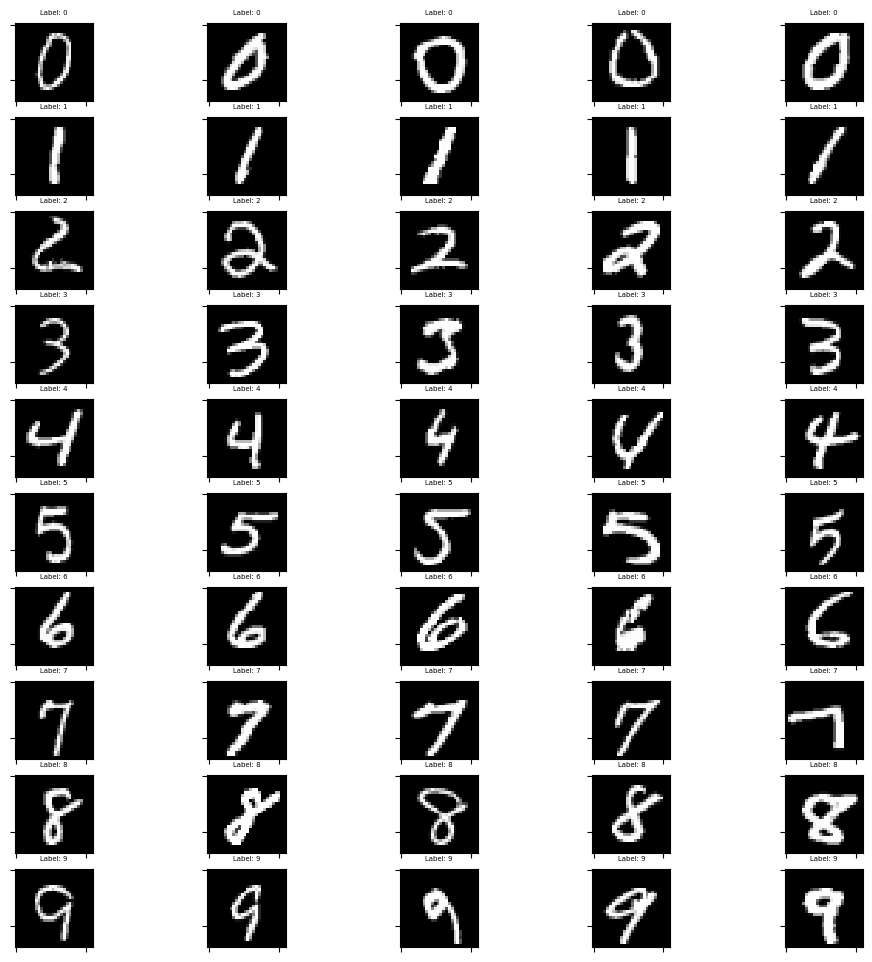

In [146]:
# Display 5 images from each of the available classes from the training dataset
fig, axs = plt.subplots(10, 5, figsize=(12, 12))

for y, y_name in enumerate(list(y_train.cat.categories)):
    for x in range(5):
        index = np.random.choice(y_train[y_train.values == y_name].index)
        axs[y, x].imshow(X_train.loc[index].values.reshape(28,28), cmap='gray')
        axs[y, x].set_title('Label: {}'.format(y_name), fontsize = 5)
        axs[y, x].set_yticklabels([])
        axs[y, x].set_xticklabels([])

In [ ]:


# Split the data into training and test samples
X_train, X_test, y_train, y_test =
